# Convolutional Denoising Autoencoders for image noise reduction

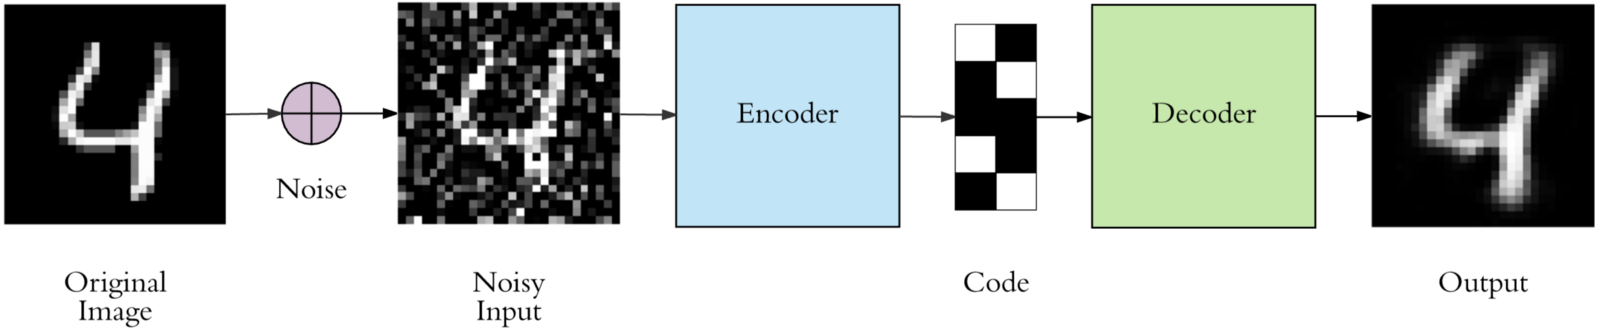

This project will focus on Convolutional Denoising Autoencoders where we will train a denoising autoencoder from scratch using __Keras and TensorFlow__. Here is a quick peek into the

## Convolutional Denoising Autoencoders

Autoencoders are typically used for representing data in lower-dimensional space(latent feature space), usually for dimensionality reduction tasks. They achieve this task by first converting input data into a lower-dimensional encoding (bottle-neck) and then take that encoding to reconstruct the original data as an output. In this way, the model learns the important aspects of input data as latent features(ignoring non-important information) such that it is able to recreate it efficiently.

Denoising Autoencoders are slightly different in working. They learn to capture only useful information from input data (ignoring noise) by changing the reconstruction criterion. Denoising Autoencoders are used for reducing noise from noisy datasets. They take noisy data points as input and reconstruct the clean version as output thus the input data and output data are not the same in the case of the Denoising Autoencoders.

This kind of training (__noisy data -> clean data__), helps the model to learn only valuable features(ignoring the noise) in latent space, and thus it re-constructs the clean version. This kind of setup is utilized in multiple applications for cleaning real-world noisy datasets.

Denoising Autoencoder will only be able to remove noise from the dataset when the following two conditions are true-



1.   __Original Features of data are stable and robust to noise.__
2.   __The model should be able to learn the useful structure from the distribution of the dataset.__

## 2. Data Preparation

To train a denoising autoencoder on MNIST handwritten digits dataset available through Keras. 

### IMPORT LIBRARIES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.keras.datasets import mnist

### IMPORT DATASET

In [ ]:
(trainX, trainy), (testX, testy) = mnist.load_data()
 
print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

11493376/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


MNIST handwritten digits dataset comes with 60K labeled handwritten digit images in the training partition and 10K images in the test partition. Here is a glimpse of 5 images from the dataset. Each image is of 28 * 28 dimensions.

### PERFORM DATA VISUALIZATION

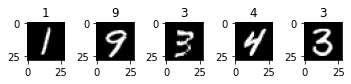

In [ ]:
for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

### Creating Noisy Data

As our task is to learn a denoising autoencoder, we will need noisy images (for corresponding clean images) for training the network. We will manually add four different kinds of noise into our training and test images.

Here are the python scripts capable of adding following four different kinds of noise to the input images-


1.   Gaussian Noise
2.   Salt and Pepper Noise
3.   Poisson Noise
4.   Speckle Noise

#### Gaussian Noise

In [ ]:
def guassian_noise(image):
    r,c= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gaussian = np.random.normal(mean,sigma,(r,c))
    gaussian = gaussian.reshape(r,c)
    noisy = image + gaussian
    return noisy

#### Salt and Pepper Noise

In [ ]:
def salt_and_pepper_noise(image):
    ratio = 0.9
    amount = 0.1
    noisy = np.copy(image)
     
    salt_count = np.ceil(amount * image.size * ratio)
    coords = [np.random.randint(0, i - 1, int(salt_count)) for i in image.shape]
    noisy[coords] = 1
 
    pepper_count = np.ceil(amount* image.size * (1. - ratio))
    coords = [np.random.randint(0, i - 1, int(pepper_count)) for i in image.shape]
    noisy[coords] = 0
    return noisy

#### Poisson_Noise

In [ ]:
def poisson_noise(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy

#### speckle_noise

In [ ]:
def speckle_noise(image):
    r,c = image.shape
    speckle = np.random.randn(r,c)
    speckle = speckle.reshape(r,c)        
    noisy = image + image * speckle
    return noisy    
 


#### Random selection of noise

In [ ]:
def add_noise(image):
    p = np.random.random()
    if p <= 0.25:
        #print("Guassian")
        noisy = guassian_noise(image)
    elif p <= 0.5:
        #print("SnP")
        noisy = salt_and_pepper_noise(image)
    elif p <= 0.75:
        #print("Poison")
        noisy = poisson_noise(image)
    else:
        #print("speckle")
        noisy = speckle_noise(image)
    return noisy

#### NOISE DATA VISUALIZATION

Corrupted Example Samples


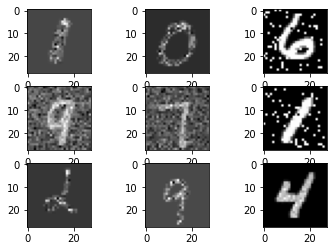

In [ ]:
print ("Corrupted Example Samples")
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    noisy = add_noise(trainX[i]/255)
    plt.imshow(noisy, cmap='gray')
plt.show()

 ### PERFORM DATA PREPROCESSING

- Prepare training and test datasets separately for clean and noisy versions of images.
- Noisy images will be fed as input and the reconstructed images would be compared with the cleaner versions of the corresponding images. 
- Images are reshaped to add an extra dimension for channels

In [ ]:
train_clean = [image/255 for image in trainX]
test_clean = [image/255 for image in testX]
 
train_noisy = [add_noise(image/255) for image in trainX]
test_noisy = [add_noise(image/255) for image in testX]
 
train_clean = np.reshape(train_clean, (60000, 28, 28, 1))
test_clean = np.reshape(test_clean, (10000, 28, 28, 1))
 
train_noisy = np.reshape(train_noisy, (60000, 28, 28, 1))
test_noisy = np.reshape(test_noisy, (10000, 28, 28, 1))
 
print (train_clean.shape, train_noisy.shape, test_clean.shape, test_noisy.shape)


(60000, 28, 28, 1) (60000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


## 3. Training Convolutional Denoising Autoencoder

In this  architecture and train it on the prepared dataset.

### Architecture

The model starts with an input layer that takes a batch of images as input with each image having dimensions=(28 * 28 * 1). 

In [ ]:
inputshape=(28, 28, 1)


#### Encoder part

- The first few layers(encoder part) are composed of Convolutional layers followed by MaxPooling layers. 
- The encoder part of the model downsamples the image across width and height and extracts features.

In [ ]:
import tensorflow
 
input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))
 
#Encoder part
encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
 
encoder = tensorflow.keras.layers.Conv2D(128, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
 
encoder = tensorflow.keras.layers.Conv2D(256, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

####  Decoder Part

These extracted features from the encoder part are passed into the decoder part as input where the decoder reconstructs the image of the original dimensions. The decoder part is consists of multiple De-convolution layers, each followed by an upsampling layer.

In [ ]:
#Decoder Part
decoder = tensorflow.keras.layers.Conv2DTranspose(256, (3,3), activation='relu')(encoder)
 
decoder = tensorflow.keras.layers.Conv2DTranspose(128, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
decoded = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

#### Loss

The final task is to compare the reconstructed image with the cleaner version of the input image. As these images are represented with pixel values, we can use mean squared error(MSE) to quantify the goodness of the autoencoder. We will use the Adam optimizer that will tune the model weights such that MSE is reduced.

In [ ]:
autoencoder = tensorflow.keras.models.Model(inputs=input_data, outputs=decoded)
# Compile model
autoencoder.compile(loss='mse', optimizer='adam',metrics=['mse', 'accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0     

#### Training

train the model on training data where noisy images are passed as input and clean images are passed as the output of the model. The test dataset is kept as validation data in order to check the MSE on test batches. 

In [ ]:
# Fit the model
history =autoencoder.fit(train_noisy, train_clean, epochs=30, batch_size=64, verbose=1,validation_data=(test_noisy, test_clean))

Epoch 1/30
938/938 [==============================] - 40s 9ms/step - loss: 0.0254 - mse: 0.0254 - accuracy: 0.8088 - val_loss: 0.0139 - val_mse: 0.0139 - val_accuracy: 0.8108
Epoch 2/30
938/938 [==============================] - 8s 9ms/step - loss: 0.0120 - mse: 0.0120 - accuracy: 0.8131 - val_loss: 0.0111 - val_mse: 0.0111 - val_accuracy: 0.8120
Epoch 3/30
938/938 [==============================] - 8s 9ms/step - loss: 0.0101 - mse: 0.0101 - accuracy: 0.8138 - val_loss: 0.0099 - val_mse: 0.0099 - val_accuracy: 0.8131
Epoch 4/30
938/938 [==============================] - 8s 9ms/step - loss: 0.0092 - mse: 0.0092 - accuracy: 0.8141 - val_loss: 0.0092 - val_mse: 0.0092 - val_accuracy: 0.8129
Epoch 5/30
938/938 [==============================] - 8s 9ms/step - loss: 0.0085 - mse: 0.0085 - accuracy: 0.8142 - val_loss: 0.0088 - val_mse: 0.0088 - val_accuracy: 0.8134
Epoch 6/30
938/938 [==============================] - 8s 9ms/step - loss: 0.0081 - mse: 0.0081 - accuracy: 0.8144 - val_loss: 0.0

#4. EVALUATE TRAINED MODEL PERFORMANCE

In [ ]:
autoencoder.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
evaluation = autoencoder.evaluate(np.array(test_noisy.reshape(-1, 28, 28, 1)), test_clean.reshape(-1, 28, 28, 1))
print("%s: %.2f%%" % (autoencoder.metrics_names[2], evaluation[2]*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0070 - mse: 0.0070 - accuracy: 0.8136
accuracy: 81.36%


In [ ]:
predicted=autoencoder.predict(np.array(test_noisy[:10].reshape(-1, 28, 28, 1)))

In [ ]:
predicted.shape

(10, 28, 28, 1)

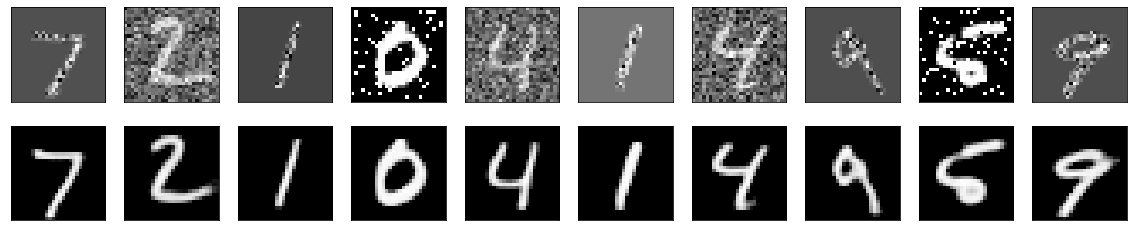

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([np.array(test_noisy[:10]), predicted], axes):
      for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)